# Fitting an optimal APD to EBSD data

In [1]:
# SETUP:

# reloading modules if needed
from importlib import reload

# first import the whole package
import PyAPD

# then load all the functions in the .py files in the .../PyAPD/ directory:
from PyAPD import *

import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

In [2]:
# Load the grain file:

file = "../../../../data/2D_Tata_Steel_paper_example/sample_lc_steel_grain_file_final.txt"
seed_id = (0,1)
volumes_id = (5)
orientation_id = (2,3,4)

X, A, TV, EBSD = load_setup_from_EBSD_data_2D(file = file,
                                             seed_id = seed_id,
                                             volumes_id = volumes_id,
                                             orientation_id = orientation_id,
                                             normalise_matrices = True,
                                             angle_in_degrees = False,
                                             device = device,
                                             dt = dt)
X = X.to(device,dtype=dt)
A = A.to(device,dtype=dt)
TV = TV.to(device,dtype=dt)
N, D = X.shape

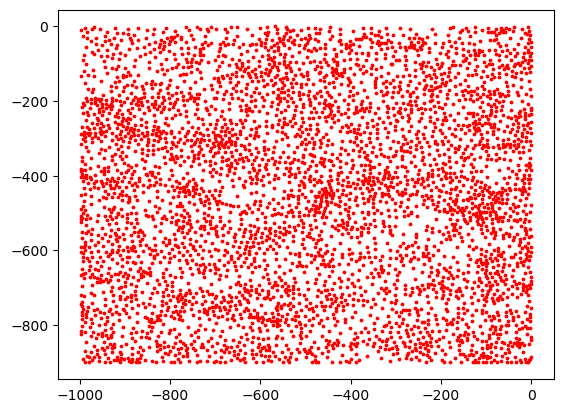

In [3]:
# Plot the seeds:
plt.scatter(X[:,0].cpu().numpy(),X[:,1].cpu().numpy(),c='r',s=3)

In [4]:
# Manually enter the correct domain size:
dom_x = [-999.02675,0.49975]
dom_y = [-901.0003,0.5003]
domain = torch.tensor([dom_x,dom_y])

In [5]:
# Compute total area and show largest and smallest grain:
total_area = TV.sum()
print("Largest grain: ", torch.max(TV).cpu().numpy(), "Smallest grain: ",torch.min(TV).cpu().numpy())

Largest grain:  2073.79661128761 Smallest grain:  11.000898081641


In [6]:
# Construct an APD system:
apd1 = apd_system(D=2,
                  domain = domain,
                  X = X,
                  As = A,
                  heuristic_W = True, # the default set of weights is the heuristic guess
                  target_masses = TV/total_area,
                  dt = torch.float64,
                  device = device,
                  pixel_size_prefactor = 1.0,
                  error_tolerance = 0.01
                  )

In [7]:
# Check number of grains
apd1.N

4587

In [8]:
# Check pixel parameters
apd1.pixel_params

(2863, 2863)

In [9]:
# Compute domain length ratio for plots
len_x = dom_x[1] - dom_x[0]
len_y = dom_y[1] - dom_y[0]

ratio = len_x / len_y

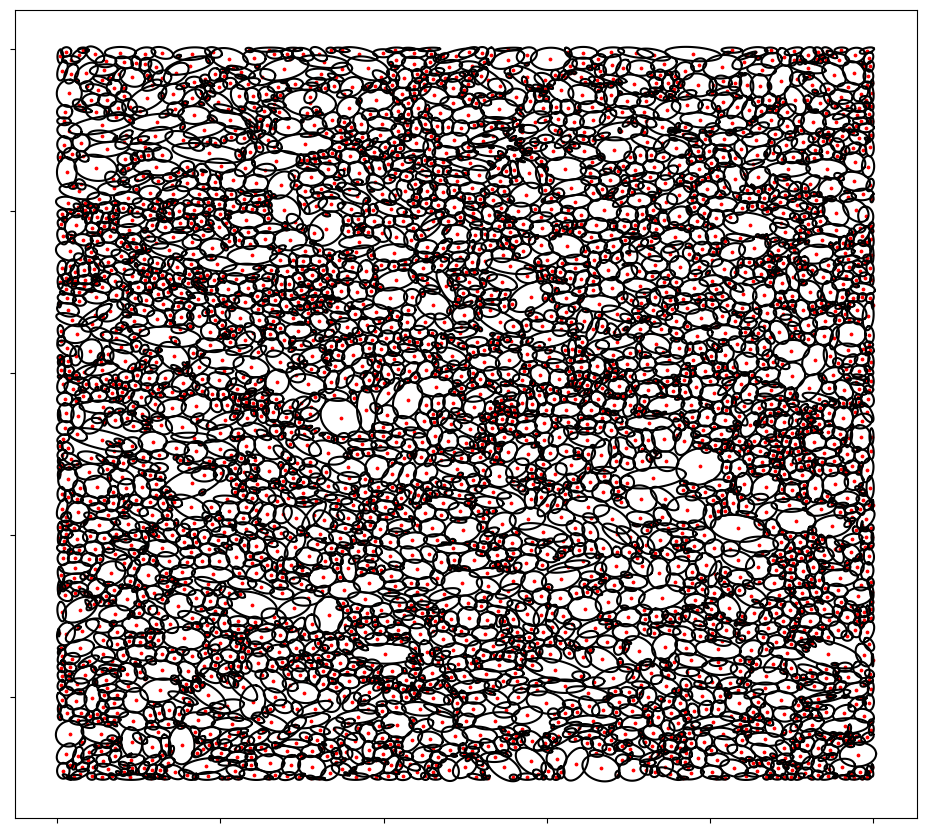

In [10]:
# Plot the ellipses and centroids
ff, ax1 = apd1.plot_ellipses()

ff.set_size_inches(ratio*10.5, 10.5, forward=True)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ff
ff.savefig('ebsd_data_ellipses_final.pdf')

In [11]:
# Save heuristic guess
W_heuristic = copy.deepcopy(apd1.W)

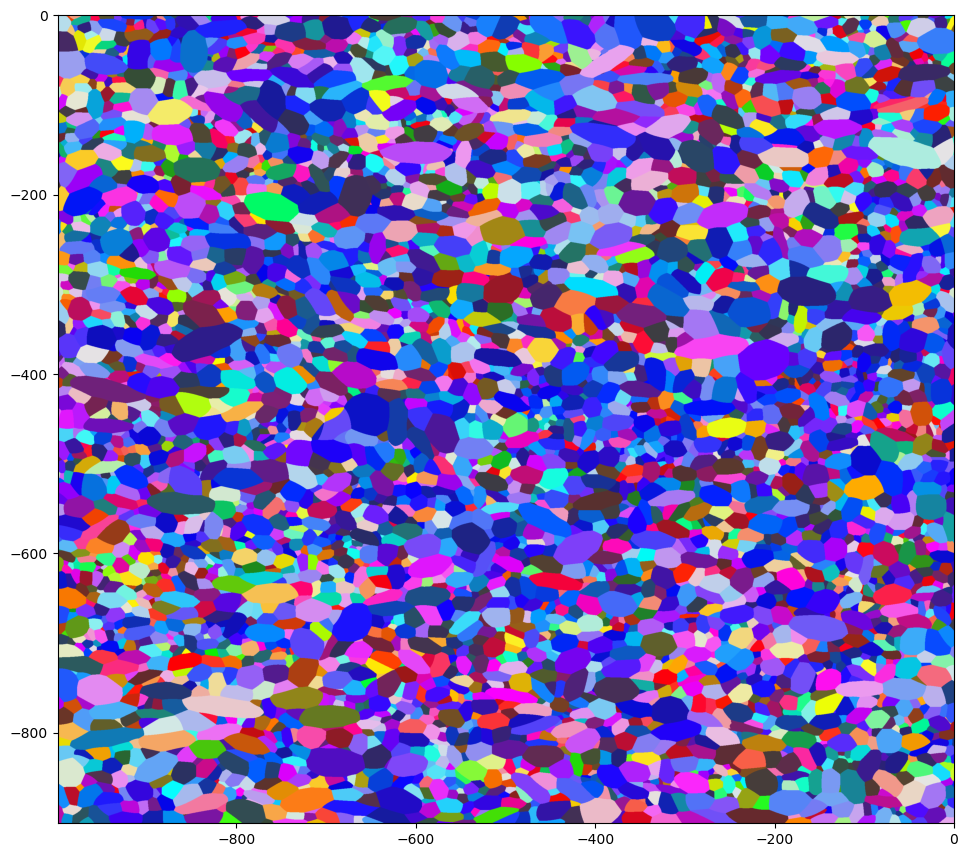

In [12]:
# Plot the APD generated by the heuristic guess:
apd1.assemble_pixels()
img = apd1.assemble_apd(color_by = EBSD[:,-3:])
img2 = img.reshape(apd1.pixel_params + (3,)).transpose(0,1).cpu()

fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(ratio*10.5, 10.5, forward=True)
ax1.imshow(img2, origin='upper', extent = torch.flatten( apd1.domain ).tolist())

In [13]:
# Check that error is still huge
Dg, error = apd1.check_optimality(return_gradient_and_error=True)

Precision loss detected!
Percentage error =  380.39910107162774


In [14]:
# Save the assignment vector (or "the grain map") for later:
img1 = apd1.assemble_apd()

In [15]:
# Solve the OT problem to get optimal weights:
apd1.optimality = False
apd1.check_optimality()
apd1.find_optimal_W()

Precision loss detected!
Percentage error =  380.39910107162774
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.1099153069, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -64128011.527938
         Iterations: 240
         Function evaluations: 401
It took 50.349161863327026 seconds to find optimal W.


In [16]:
# Check optimality
apd1.check_optimality()

The APD is optimal!
Percentage error =  0.9864448173073024


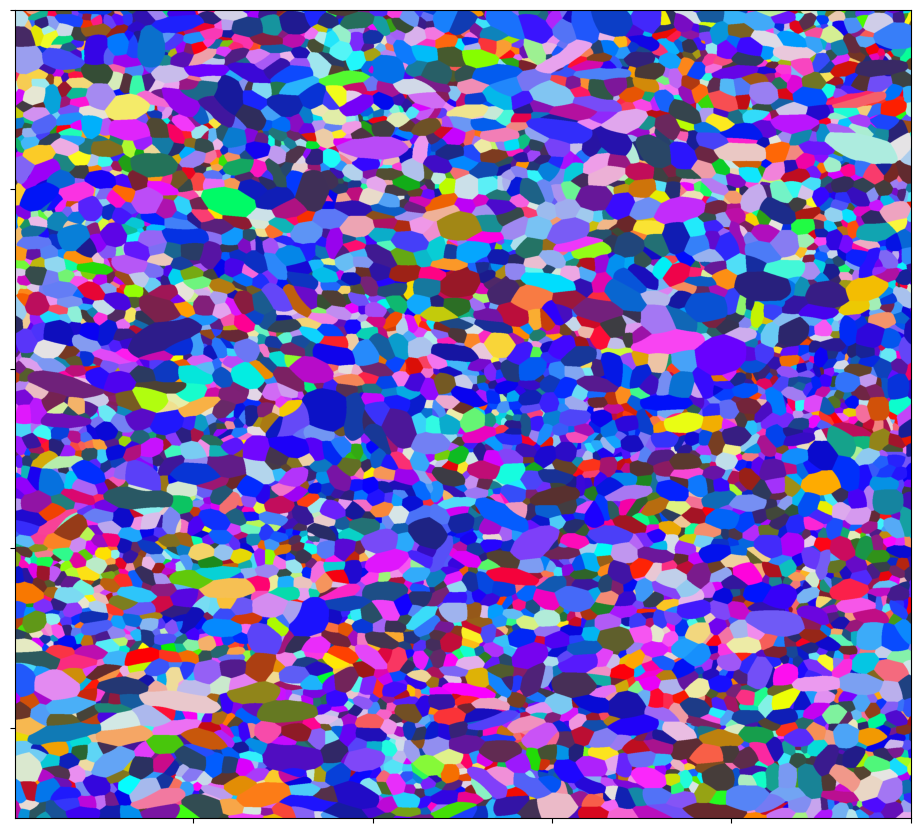

In [17]:
# Plot the optimal APD
img = apd1.assemble_apd(color_by = EBSD[:,-3:])
img2 = img.reshape(apd1.pixel_params + (3,)).transpose(0,1).cpu()
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(ratio*10.5, 10.5, forward=True)
ax1.imshow(img2, origin='upper', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.savefig('optimal_apd_python.pdf')

In [18]:
# Save optimal weights
W_optimal = copy.deepcopy(apd1.W)

In [19]:
# Save the optimal APD grain map:
img2 = apd1.assemble_apd()

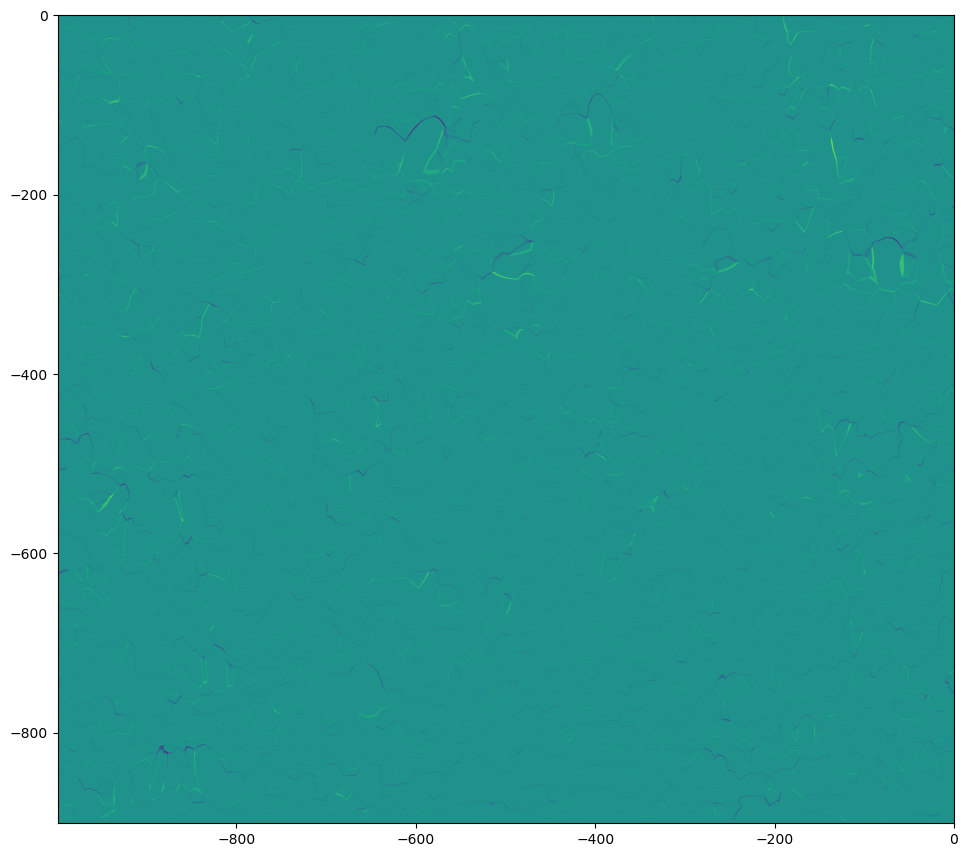

In [20]:
# Visually compare the difference
img_diff = (img1-img2).reshape(apd1.pixel_params)

img_diff = img_diff.cpu()
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(ratio*10.5, 10.5, forward=True)
ax1.imshow(img_diff, origin='upper', extent = torch.flatten( apd1.domain ).tolist())

In [21]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
import math
all_pixels = math.prod(apd1.pixel_params)
misassigned_pixels = (img_diff != 0).sum()
misassigned_pixels/all_pixels

tensor(0.0436753799)

In [22]:
# Check the runtime when starting from a zero initial guess:
apd1.set_W(W=torch.zeros(apd1.N).to(device=apd1.device,dtype=apd1.dt))
apd1.optimality = False
apd1.check_optimality()
apd1.find_optimal_W()

Precision loss detected!
Percentage error =  2946.417061479574
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.1099153069, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -64128014.255646
         Iterations: 411
         Function evaluations: 810
It took 101.61042213439941 seconds to find optimal W.


In [23]:
apd1.check_optimality()

The APD is optimal!
Percentage error =  0.986444817306309


# Fitting distributions and generating artificial microstructure

In [24]:
# SETUP

colors = [(230/255,97/255,1/255),
(253/255,184/255,99/255),
(178/255,171/255,210/255),
(94/255,60/255,153/255)]

import scipy
import scipy.stats
import pandas as pd

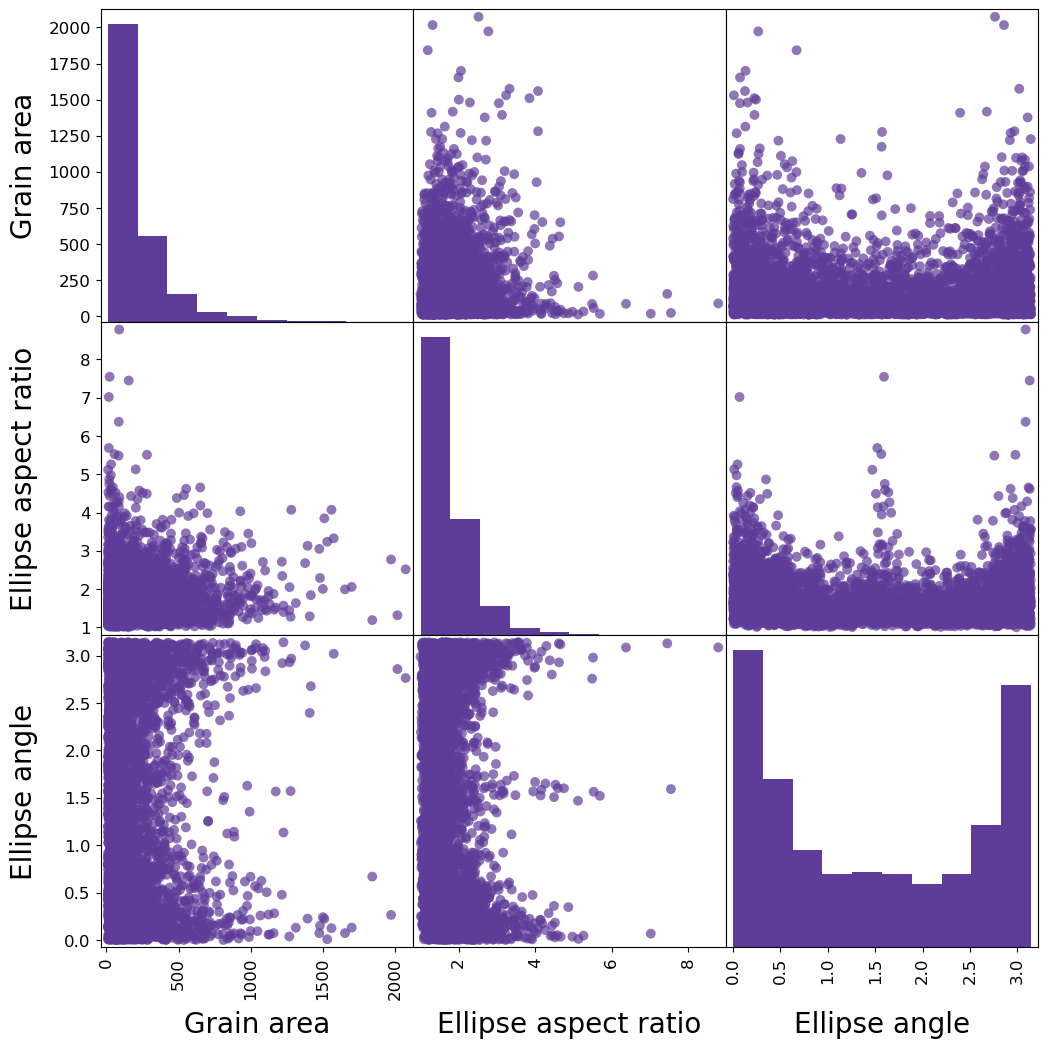

In [25]:
# Process the EBSD data and plot it as a scatter matrix plot
TV_log = torch.log(TV).cpu().numpy()
ratios = (EBSD[:,orientation_id[0]]/EBSD[:,orientation_id[1]])
ratios_log = torch.log(ratios).cpu().numpy()
angles = (EBSD[:,orientation_id[-1]]).cpu().numpy()

data = [[TV.cpu().numpy()[i], ratios.cpu().numpy()[i], angles[i]] for i in range(len(TV_log))]

df = pd.DataFrame(data, columns=['Grain area','Ellipse aspect ratio','Ellipse angle'])
axes = pd.plotting.scatter_matrix(df, alpha=0.7,diagonal='hist', hist_kwds={'color':colors[3]},
                                  figsize=(10.5,10.5),s=200, color=colors[3])
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(0)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.yaxis.label.set_rotation(90)
    ax.yaxis.label.set_ha('center')
    ax.get_yaxis().set_label_coords(-0.2,0.5)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(12) 

    
    ax.xaxis.label.set_ha('center')
    ax.get_xaxis().set_label_coords(0.5,-0.2)

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.savefig('ebsd_scatter_matrix_plot_final.pdf')

In [26]:
# Fix random seed
seed = 50

In [27]:
# Use kernel smoothing approach to sampling
import openturns as ot

data = [[TV[i], ratios[i], angles[i]] for i in range(len(TV))]
kernel = ot.Uniform()
ks = ot.KernelSmoothing(kernel)
fittedDist = ks.build(data)

In [28]:
ot.RandomGenerator.SetSeed(seed)

sample = fittedDist.getSample(apd1.N)
np_sample = np.array(sample)

# Adjustments to make the artificial data physically relevant
np_sample[:,0] = np_sample[:,0] - np_sample[:,0].min() + 1.0
shift = 1.0 - np_sample[:,1].min()
np_sample[:,1] = np_sample[:,1] + shift

In [29]:
TV = torch.tensor(np_sample[:,0])
TV = TV / TV.sum()
ratios = torch.tensor(np_sample[:,1])
thetas = torch.tensor(np_sample[:,2])
# Take circularity of the angles into account
thetas[thetas > np.pi] -= np.pi
thetas[thetas < 0.0] += np.pi

np_sample[:,2] = np.array(thetas)

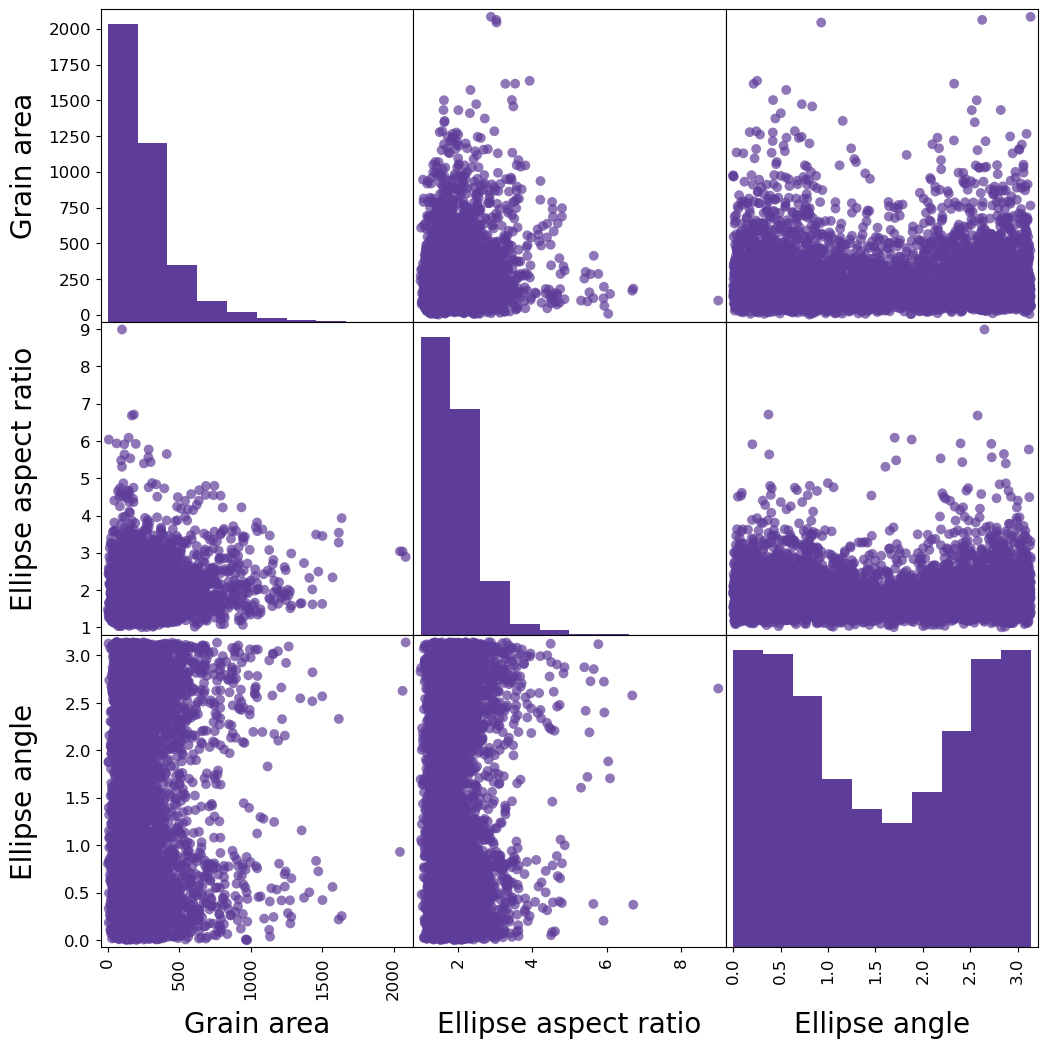

In [30]:
import pandas as pd

#fig = plt.figure()

df = pd.DataFrame(np_sample, columns=['Grain area','Ellipse aspect ratio','Ellipse angle'])
axes = pd.plotting.scatter_matrix(df, alpha=0.7,diagonal='hist', hist_kwds={'color':colors[3]},
                                  figsize=(10.5,10.5),s=200,color=colors[3])
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(0)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.yaxis.label.set_rotation(90)
    ax.yaxis.label.set_ha('center')
    ax.get_yaxis().set_label_coords(-0.2,0.5)
#    ax.get_major_ticks().label.set_fontsize(14) 
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(12) 

    
    ax.xaxis.label.set_ha('center')
    ax.get_xaxis().set_label_coords(0.5,-0.2)

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.savefig('ebsd_scatter_matrix_plot_artificial_final.pdf')  

In [31]:
# Prepare data to be passed to the APD system
a_s = torch.sqrt(ratios)
b_s = 1.0/a_s

ss = torch.sin(thetas)
cc = torch.cos(thetas)
rots = torch.stack([torch.stack([cc, -ss],dim=1),
                    torch.stack([ss, cc], dim=1)],dim=2)
IIs = torch.stack([torch.stack([1/a_s**2,torch.tensor([0.0]*N)],dim=1),
                  torch.stack([torch.tensor([0.0]*N),1/b_s**2],dim=1)],dim=2)
As = rots @ IIs @ torch.transpose(rots,1,2)

In [32]:
# Random sample of seed points
apd1.radius_of_exclusion = 0.2
torch.manual_seed(seed)
X = sample_seeds_with_exclusion(apd1.N,dim=apd1.D,
                                radius_prefactor = apd1.radius_of_exclusion,
                                verbose=True)

X = apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * X.to(device=apd1.device, dtype = apd1.dt)

347 proposed seed points have been excluded.


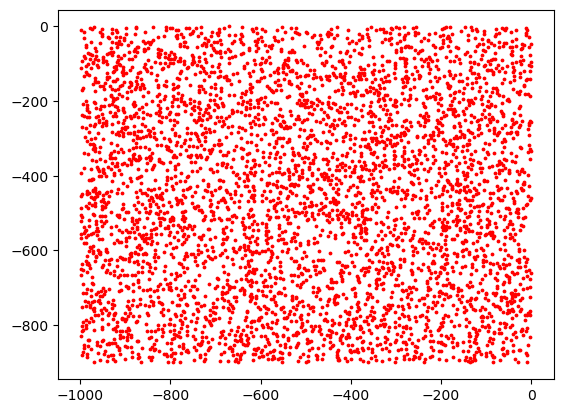

In [33]:
# Plot the seed points
plt.scatter(X[:,0].cpu().numpy(),X[:,1].cpu().numpy(),c='r',s=3)

In [34]:
# Pass data to the APD system
apd1.set_X(X = X)
apd1.set_As(As = As)
apd1.set_target_masses(target_masses = TV)
apd1.set_W(W=torch.zeros(apd1.N).to(device=apd1.device,dtype=apd1.dt))
apd1.error_tolerance = 0.1
apd1.set_pixel_params()
apd1.assemble_pixels()
apd1.check_optimality()

Precision loss detected!
Percentage error =  14177.454118038173


In [35]:
# Check pixel params
apd1.pixel_params

(3510, 3510)

In [36]:
# Find first optimal set of weights
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0731003237, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -225072065.666975
         Iterations: 461
         Function evaluations: 472
It took 92.76692748069763 seconds to find optimal W.


In [37]:
# Check optimality
apd1.check_optimality()

The APD is optimal!
Percentage error =  9.952987342437785


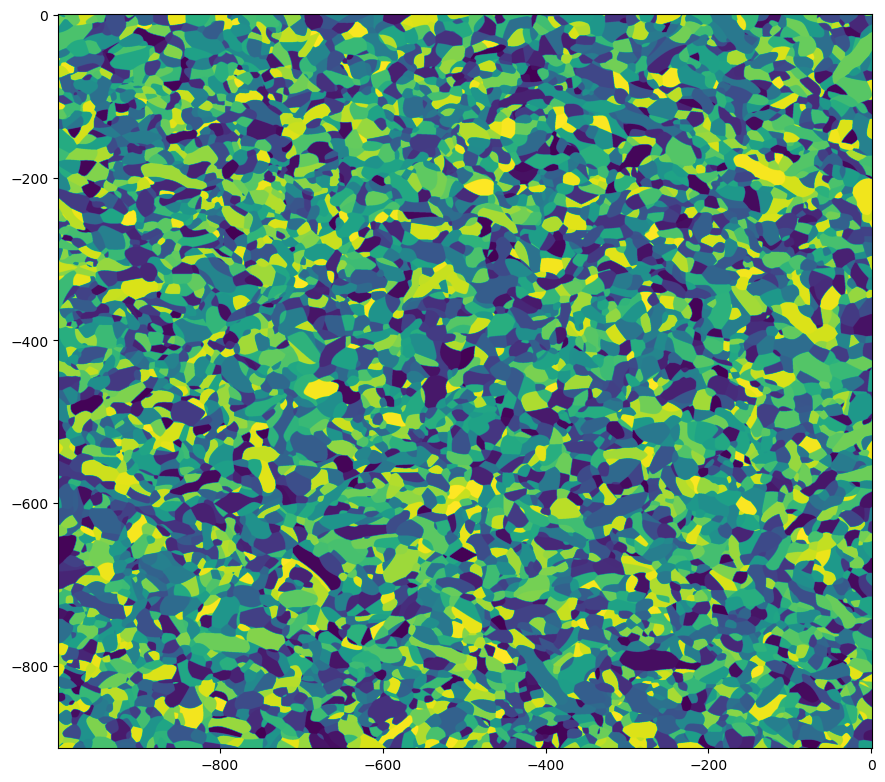

In [38]:
# Plot the resulting APD
fig1, ax1 = apd1.plot_apd()

In [39]:
# Regularise it by running 5 iterations of the Lloyds algorithm
apd1.Lloyds_algorithm(K=5,verbosity_level = 2)

Lloyds iteration: 0
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0731003237, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -225072068.533288
         Iterations: 1
         Function evaluations: 3
It took 0.5274748802185059 seconds to find optimal W.
The APD is optimal!
Percentage error =  9.952987342437785
Lloyds iteration: 1
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0731003237, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -58300971.661033
         Iterations: 329
         Function evaluations: 341
It took 67.17029213905334 seconds to find optimal W.
The APD is optimal!
Percentage error =  4.740821955122725
Lloyds iteration: 2
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0731003237, device='cud

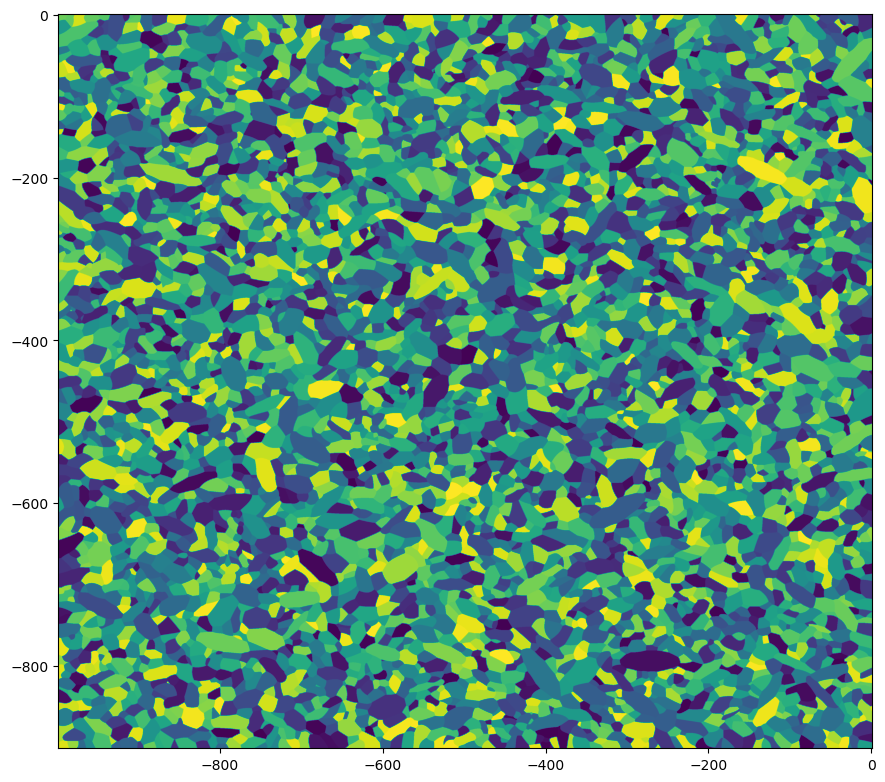

In [40]:
# Plot the resulting APD
fig2, ax2 = apd1.plot_apd()

In [41]:
# Lower the error tolerance, leading to a refined mesh of pixels
apd1.error_tolerance = 0.05
apd1.set_pixel_params()
apd1.assemble_pixels()
apd1.pixel_params

(4965, 4965)

In [42]:
# Solve again
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0365501618, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -49757471.196797
         Iterations: 88
         Function evaluations: 93
It took 33.89867377281189 seconds to find optimal W.


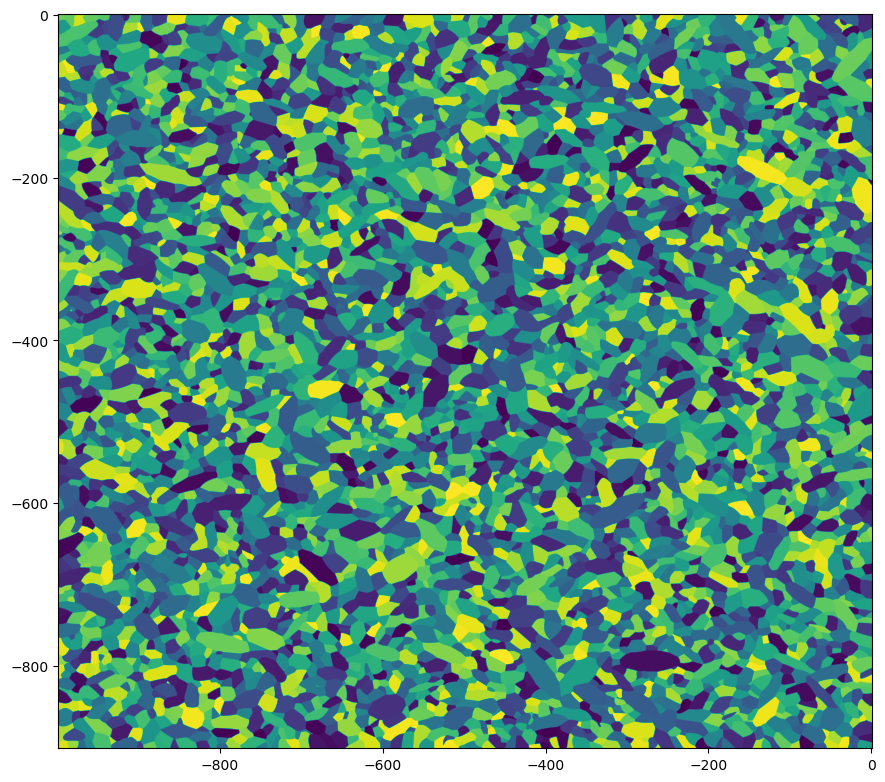

In [43]:
# Plot the resulting APD
fig3, ax3 = apd1.plot_apd()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0146200647, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -49757772.800762
         Iterations: 55
         Function evaluations: 58
It took 50.43124580383301 seconds to find optimal W.


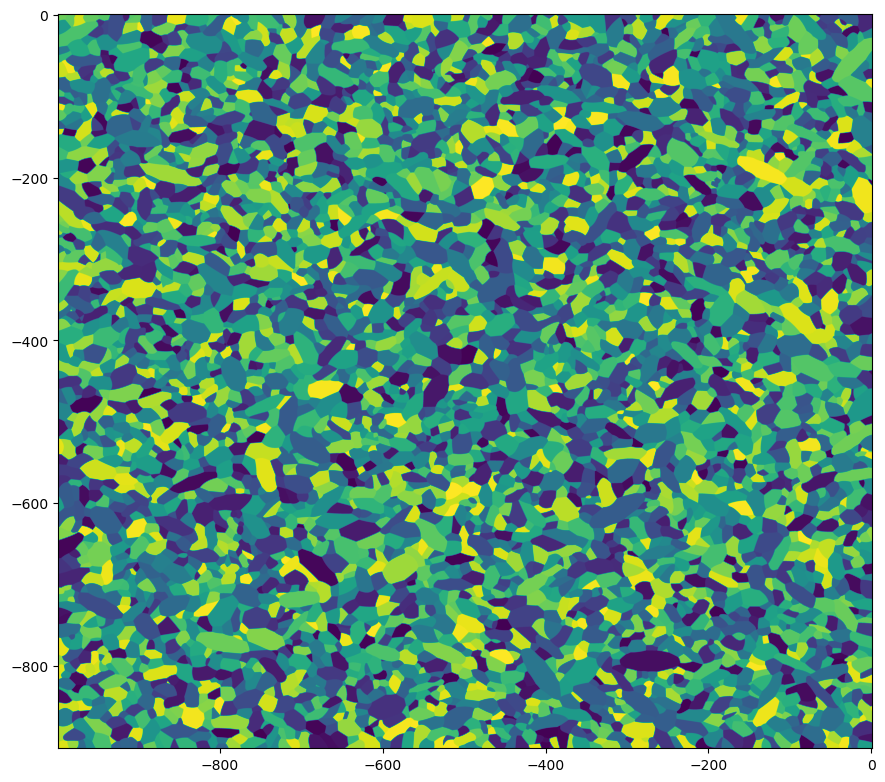

In [44]:
# One final time:
apd1.error_tolerance = 0.02
apd1.set_pixel_params()
apd1.assemble_pixels()
apd1.pixel_params

apd1.find_optimal_W()

fig4, ax4 = apd1.plot_apd()

In [45]:
# Check optimality
apd1.check_optimality()

The APD is optimal!
Percentage error =  1.7014864161185002


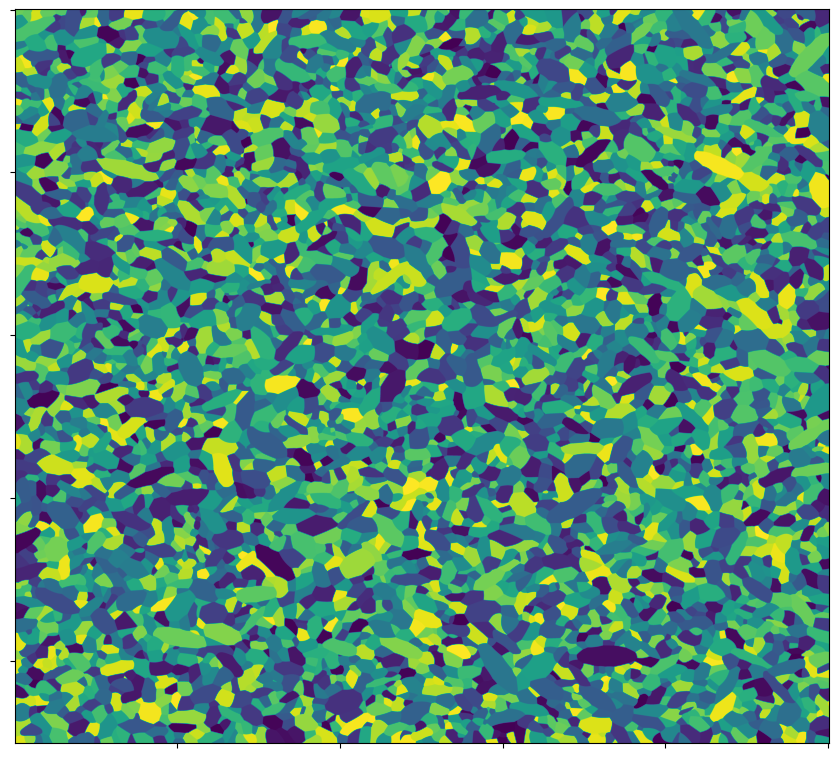

In [46]:
# Save the figure
ax4.set_xticklabels([])
ax4.set_yticklabels([])

fig.set_size_inches(ratio*10.5, 10.5, forward=True)
fig4.savefig('artificial_apd_final.pdf')
fig4